In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from skmultilearn.adapt import MLkNN
from sklearn.metrics import hamming_loss, accuracy_score
import string 

import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, roc_auc_score 
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
import copy 

from nltk.tokenize import word_tokenize
from sklearn import preprocessing

In [2]:
#filter out only rows with 1 or more labels
#randomly sample 1000 rows

In [3]:
#filtered_df = df[(df[df.columns.tolist()[2:]].sum(axis=1) != 0)]

In [4]:
path = '../Multilabel_text_classifcation/jigsaw-toxic-comment-classification-challenge/'
df = pd.read_csv(path+'train.csv')
df_test = pd.read_csv(path+'test.csv')
df_submission = pd.read_csv(path+'sample_submission.csv')

filtered_df = df[(df[df.columns.tolist()[2:]].sum(axis=1) != 0)]


In [5]:
df_sample_without_replacement = filtered_df.sample(2000)
df_validation_labelled = df_sample_without_replacement.iloc[:1000]
df_train_labelled = df_sample_without_replacement.iloc[1000:]
df_test_sample = df_test.sample(4000)


In [6]:
df_validation_labelled.to_csv('multiclass_validation_labelled_sample.csv', index=False)
df_train_labelled.to_csv('multiclass_train_labelled_sample.csv', index=False)
df_test_sample.to_csv('multiclass_df_test_sample.csv', index=False)


## for future references (to prevent constant undersampling)

In [7]:
df_train_labelled = pd.read_csv('multiclass_train_labelled_sample.csv')
df_validation_labelled = pd.read_csv('multiclass_validation_labelled_sample.csv')
df_test_sample = pd.read_csv('multiclass_df_test_sample.csv')

In [8]:
df_train_labelled
#for multilabel, a 6th column with the list of all labels (e.g. for [0] its [1,1,1,0,1,0])

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,ace24540859c7e64,"Oh shit, there seems to be a case here, Marsh ...",1,0,0,0,0,0
1,948d9060f83ac76c,"Tesc, where did you go? Were you in fact a so...",1,0,0,0,0,0
2,dc51c66ff7e78396,"your all a bunch of idiots, rename the page ha...",1,0,0,0,1,0
3,ee0c1d905ad291c8,warning? \n\nwhy did you warn me? for what? im...,1,0,0,0,1,0
4,b13539a97f762250,"""\n\nthank you Fut. Perf. once more you remain...",1,0,0,0,0,0
...,...,...,...,...,...,...,...,...
995,fc6d45d108129fc8,Goethean and me\n\nI would like you to know I ...,1,0,0,0,0,0
996,235fc68b9664fecf,Message\nHi! Man you just provoked me to tell ...,0,0,1,0,0,0
997,6eab71baeaf14caf,Now that Specifico has chimed in with the usua...,1,0,1,0,0,0
998,b11a32b527540196,U BASTARDS STOP BLOCKING ME!\nAAAAAAAAAAH\nf u...,1,0,1,0,1,0


In [9]:
df_test_sample

,id,comment_text
0,e5d5becff8ad83c8,sodomised by a bunch of starved midget pirates...
1,c199fd57e877767a,""" \n\n == Stark? == \n\n Hi, I don't want to ""..."
2,4b935ace1ed43454,==Thanks== \n Appreciate it! I wish the other ...
3,0639a8580dda7e40,""" \n\n == Unchanged Burgers == \n The article ..."
4,3e9965d5ad3a5ea1,2005 (UTC) \n The width seems to get properly ...
...,...,...
3995,cd7e209e9efd101b,""" \n :: It's nothing to do with recentism when..."
3996,abc63d530bf4df79,== Face of Canada == \n\n I think the user is ...
3997,4a1f80b5b87437f1,":Good link! Personally, I prefer watching pain..."
3998,4e91f0f04eced47f,"Yeah, I agree ferrariman, but saying stuff lik..."


# multiclass

In [10]:
def training_model(X_train,y_train,vectorizer): 
    pipeline = Pipeline([('vect', vectorizer),
                         ('chi',  SelectKBest(chi2, k=1200)),
                         ('clf', RandomForestClassifier())])
    model = pipeline.fit(X_train, y_train) #only used in the trained data
    return model

def cleaning_data(part_df):
    words = stopwords.words("english")
    part_df['comment_text_cleaned']= part_df['comment_text'].apply(lambda x: word_tokenize(x))
    part_df['comment_text_cleaned']= part_df['comment_text_cleaned'].apply(lambda x: [i for i in x if i not in words])
    part_df['comment_text_cleaned']= part_df['comment_text_cleaned'].apply(lambda x: " ".join([i for i in x if i not in string.punctuation]))
    return part_df

def vectorized_data(part_df):
    vectorizer = TfidfVectorizer(min_df= 3, stop_words="english", sublinear_tf=True, norm='l2', ngram_range=(1, 2))
    #final_features = vectorizer.fit_transform(part_df['comment_text_cleaned']).toarray()
    return vectorizer

def clean_target(sample_df):
    sample_df['toxic_string'] = sample_df['toxic'].apply(lambda x: "".join(['toxic' for i in [x] if i == 1]))
    sample_df['severe_toxic_string'] = sample_df['severe_toxic'].apply(lambda x: "".join(['severe_toxic' for i in [x] if i == 1]))
    sample_df['obscene_string'] = sample_df['obscene'].apply(lambda x: "".join(['obscene' for i in [x] if i == 1]))
    sample_df['threat_string'] = sample_df['threat'].apply(lambda x: "".join(['threat' for i in [x] if i == 1]))
    sample_df['insult_string'] = sample_df['insult'].apply(lambda x: "".join(['insult' for i in [x] if i == 1]))
    sample_df['identity_hate_string'] = sample_df['identity_hate'].apply(lambda x: "".join(['identity_hate' for i in [x] if i == 1]))
    sample_df['target_string'] = sample_df.apply(lambda x: x['toxic_string'] + x['severe_toxic_string']+ x['obscene_string'] + x['threat_string'] + x['insult_string'] + x['identity_hate_string'], axis = 1)
    return sample_df[['comment_text_cleaned','target_string']]

In [11]:
#repeats process until no new labels can be added
def define_x_y(cleaned):
    X_train = cleaned['comment_text_cleaned']
    y_train = cleaned['target']
    return (X_train, y_train)

def training_process(cleaned):
    vectorized = vectorized_data(cleaned)
    vectorizer = vectorized
    X_train, y_train = define_x_y(cleaned)
    return training_model(X_train,y_train,vectorizer)

def train_val_scores(x, y_val, trained_model): 
    y_val_pred=trained_model.predict(x) #transform depending on which type of function you are talking about
    return precision_score(y_val,y_val_pred,average = 'weighted'),recall_score(y_val,y_val_pred,average = 'weighted')



In [12]:
import warnings
warnings.filterwarnings("ignore")

cleaned = cleaning_data(df_train_labelled)
cleaned_val = cleaning_data(df_validation_labelled)
cleaned_train = clean_target(cleaned)
cleaned_val = clean_target(cleaned_val)

# you have to clean also the comment_text in unlabelled data
cleaned_unlabelled = cleaning_data(df_test_sample)


In [13]:
dict_target = cleaned_train.groupby('target_string').count().to_dict()['comment_text_cleaned']
cleaned_train['n_samples'] = cleaned_train.target_string.map(dict_target)
cleaned_train

,comment_text_cleaned,target_string,n_samples
0,Oh shit seems case Marsh Arabs Honestly I idea...,toxic,376
1,Tesc go Were fact sockpuppet,toxic,376
2,bunch idiots rename page got news episode guid...,toxicinsult,66
3,warning warn im war ultra-christians ultra-rac...,toxicinsult,66
4,`` thank Fut Perf remain true Wikipedia Polici...,toxic,376
...,...,...,...
995,Goethean I would like know I known Goethean 6 ...,toxic,376
996,Message Hi Man provoked tell stupid messages h...,obscene,16
997,Now Specifico chimed usual bullshit time close...,toxicobscene,95
998,U BASTARDS STOP BLOCKING ME AAAAAAAAAAH f u,toxicobsceneinsult,245


In [14]:
#cleaned_train select the rows that have target with n_samples > threshold
cleaned_train_other = cleaned_train[cleaned_train['n_samples'] <= 10]
cleaned_train_other['target_string'] = 'other'
cleaned_train = cleaned_train[cleaned_train['n_samples'] > 10]
cleaned_train = cleaned_train.append(cleaned_train_other,ignore_index = True)
cleaned_train

,comment_text_cleaned,target_string,n_samples
0,Oh shit seems case Marsh Arabs Honestly I idea...,toxic,376
1,Tesc go Were fact sockpuppet,toxic,376
2,bunch idiots rename page got news episode guid...,toxicinsult,66
3,warning warn im war ultra-christians ultra-rac...,toxicinsult,66
4,`` thank Fut Perf remain true Wikipedia Polici...,toxic,376
...,...,...,...
995,User Abd Muslim Scum,other,1
996,This perfect example Wikipedia fucks bunch POV...,other,4
997,`` IT 'S MY TALK PAGE HOW DARE YOU desacrate S...,other,4
998,igger Nigger Nigger Nigger Nigger Nigger Nigge...,other,4


In [15]:
dict_target = cleaned_train.groupby('target_string').count().to_dict()['comment_text_cleaned']
cleaned_train['n_samples'] = cleaned_train.target_string.map(dict_target)
cleaned_train

,comment_text_cleaned,target_string,n_samples
0,Oh shit seems case Marsh Arabs Honestly I idea...,toxic,376
1,Tesc go Were fact sockpuppet,toxic,376
2,bunch idiots rename page got news episode guid...,toxicinsult,66
3,warning warn im war ultra-christians ultra-rac...,toxicinsult,66
4,`` thank Fut Perf remain true Wikipedia Polici...,toxic,376
...,...,...,...
995,User Abd Muslim Scum,other,44
996,This perfect example Wikipedia fucks bunch POV...,other,44
997,`` IT 'S MY TALK PAGE HOW DARE YOU desacrate S...,other,44
998,igger Nigger Nigger Nigger Nigger Nigger Nigge...,other,44


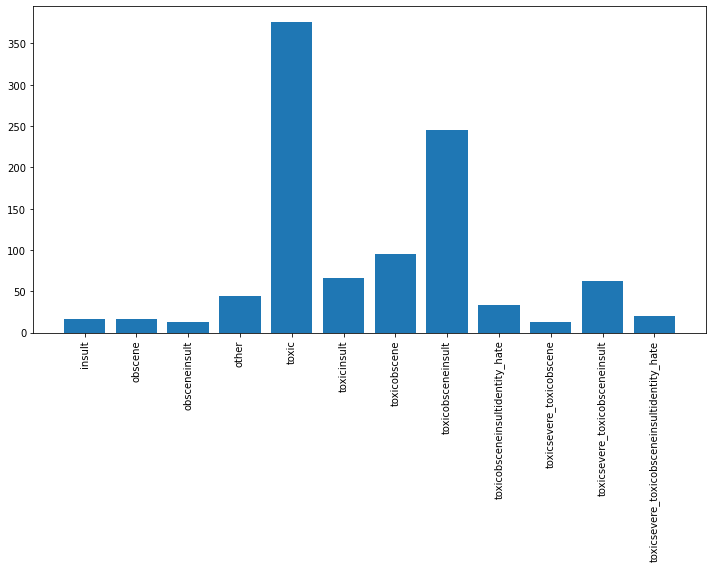

In [16]:
values = list(dict_target.values())
keys = list(dict_target.keys())

plt.figure(figsize = (10,8) )
plt.bar(keys,values, align = 'center')
plt.xticks(rotation = 90)
plt.tight_layout()

In [17]:
toxic =  {1,3,4,6,7,11,12,16}



In [18]:
# plot shows some initial imbalance in the sample
# there is therefore a possibility of sampling 'unequally' to begin with
# in order to unequally sample, also have to create target_string on entire training to know the distribution


In [19]:
#enumerate is to iterate the index and the value of the index in a list
#value = key, i is the number associated with the key
dict_labels = {value:i for i,value in enumerate(cleaned_train.drop_duplicates('target_string').target_string.tolist())}
dict_labels

{'toxic': 0,
 'toxicinsult': 1,
 'toxicobsceneinsult': 2,
 'toxicobscene': 3,
 'toxicsevere_toxicobsceneinsult': 4,
 'toxicsevere_toxicobsceneinsultidentity_hate': 5,
 'insult': 6,
 'toxicobsceneinsultidentity_hate': 7,
 'toxicsevere_toxicobscene': 8,
 'obscene': 9,
 'obsceneinsult': 10,
 'other': 11}

In [20]:
#increases size of labels not seen
#save number of last label
#n_labels = len(dict_labels)
cleaned_val_list = cleaned_val.drop_duplicates('target_string').target_string.tolist()
for value in cleaned_val_list:
    if value not in dict_labels:
        dict_labels[value] = dict_labels['other']
#        n_labels += 1

dict_labels
    

{'toxic': 0,
 'toxicinsult': 1,
 'toxicobsceneinsult': 2,
 'toxicobscene': 3,
 'toxicsevere_toxicobsceneinsult': 4,
 'toxicsevere_toxicobsceneinsultidentity_hate': 5,
 'insult': 6,
 'toxicobsceneinsultidentity_hate': 7,
 'toxicsevere_toxicobscene': 8,
 'obscene': 9,
 'obsceneinsult': 10,
 'other': 11,
 'toxicinsultidentity_hate': 11,
 'toxicsevere_toxicobscenethreatinsult': 11,
 'toxicthreat': 11,
 'toxicidentity_hate': 11,
 'toxicobscenethreatinsult': 11,
 'identity_hate': 11,
 'toxicsevere_toxic': 11,
 'toxicobscenethreatinsultidentity_hate': 11,
 'threat': 11,
 'toxicobscenethreat': 11,
 'toxicsevere_toxicthreat': 11,
 'insultidentity_hate': 11,
 'toxicobsceneidentity_hate': 11,
 'toxicthreatinsult': 11,
 'toxicsevere_toxicidentity_hate': 11,
 'toxicthreatidentity_hate': 11}

In [21]:
cleaned_train['target'] = cleaned_train['target_string'].map(dict_labels) #map will contain the key
cleaned_val['target'] = cleaned_val['target_string'].map(dict_labels)

#REMOVED BECAUSE OF ISSUES WITH LABEL ENCODER#
#label encoding doesn't ignore things that are not in the test
le = label_encoding(cleaned_train.append(cleaned_val, ignore_index  = True))
cleaned_train['target'] = le.transform(cleaned_train['target_string'])
cleaned_val['target'] = le.transform(cleaned_val['target_string'])
#unlabelled part has no target: cleaned_unlabelled['target'] = le.transform(cleaned_unlabelled['target_string'])
vectorized = vectorized_data(cleaned_train)
X_val, y_val = define_x_y(cleaned_val)

In [22]:
list_classes = np.sort(cleaned_train['target'].unique())
list_classes

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int64)

In [23]:
def pseudo_label_creation(list_classes, trained_model, cleaned_unlabelled):
    X_unlabelled = cleaned_unlabelled['comment_text_cleaned']
    y_prob = trained_model.predict_proba(X_unlabelled)
    #need to change the "propagate toxic/not-toxic bits to make it multiclass"
    #for loop to create multiple classes  
    for multiclass in list_classes:
        cleaned_unlabelled['propagate_' + str(multiclass)]=np.where(y_prob[:,multiclass] > 0.65,multiclass, -1)
    cleaned_unlabelled['new_label'] = cleaned_unlabelled.apply(lambda x: np.max([x['propagate_' + str(multiclass)] for multiclass in list_classes]), axis = 1)
    pseudo_label_df = cleaned_unlabelled[cleaned_unlabelled['new_label'] > -1]
    remaining_unlabelled_df = cleaned_unlabelled[cleaned_unlabelled['new_label'] == -1]
    pseudo_label_df.rename(columns={'new_label': 'target'}, inplace=True)
    return pseudo_label_df, remaining_unlabelled_df

In [24]:
cleaned_train_2 = copy.deepcopy(cleaned_train)
cleaned_unlabelled_2 = copy.deepcopy(cleaned_unlabelled)

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

In [26]:
def grid_search_model(X_train,y_train,vectorizer): 
    pipeline = Pipeline([('vect', vectorizer),
                         ('chi',  SelectKBest(chi2)),
                         ('clf', RandomForestClassifier())])
    param_grid = {
    "chi__k": [400, 800, 1200, 1600],
    "clf__max_depth": [50, 100],}
    search = GridSearchCV(pipeline, param_grid,cv= 5, n_jobs=2)
    model = search.fit(X_train, y_train)
    return model
    
#training model only fit the model once
#training 40 models, 4x2x5 (5 for the folds)

In [27]:
def train_val_label_scores(x, y_val, labels, trained_model): 
    y_val_pred=trained_model.predict(x)
    labels_precision = [precision_score(y_val,y_val_pred,average = 'weighted', labels = [label])
                       for label in labels]
    labels_recall = [recall_score(y_val,y_val_pred,average = 'weighted', labels = [label])
                       for label in labels]
    return labels_precision, labels_recall


In [28]:
#list of all unique labels
unique_labels = list(set(list(dict_labels.values())))
#when you convert from dict to list, you need to transform it to a set to get unique vals
#then you need to transform it back to a list
unique_labels

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [29]:
def training_process_grid_search(cleaned):
    vectorized = vectorized_data(cleaned)
    vectorizer = vectorized
    X_train, y_train = define_x_y(cleaned)
    return grid_search_model(X_train,y_train,vectorizer)

In [30]:
val_precision = []
val_recall = []
val_label_precision = []
val_label_recall = []
val_roc_auc_score = []
min_new_labels = 60
size_new_labels = 61
size_training = []

while size_new_labels > min_new_labels:
    print(len(cleaned_train_2))
    trained_model = training_process_grid_search(cleaned_train_2)
    print("Best parameter (CV score=%0.3f):" % trained_model.best_score_)
    print(trained_model.best_params_)
    X_train,y_train = define_x_y(cleaned_train_2) 
    X_val,y_val = define_x_y(cleaned_val) 
    #print('train\nprecision, recall, roc_auc_score ')
    p1,r1 = train_val_scores(X_train,y_train, trained_model)
    p2,r2 = train_val_label_scores(X_train,y_train,unique_labels, trained_model)
    #print('val\nprecision, recall, roc_auc_score ')
    p1,r1 = train_val_scores(X_val, y_val, trained_model)
    p2,r2 = train_val_label_scores(X_val, y_val,unique_labels, trained_model)
    val_precision.append(p1)
    val_recall.append(r1)    
    val_label_precision.append(p2)
    val_label_recall.append(r2)  
    pseudo_label_df, cleaned_unlabelled_2 = pseudo_label_creation(list_classes,trained_model,cleaned_unlabelled_2)
    #print('new_pseudo_labels')
    size_new_labels = len(pseudo_label_df)
    print(size_new_labels)
    size_training.append(len(cleaned_train_2))
    
    if size_new_labels > min_new_labels:
        cleaned_train_2 = cleaned_train_2.append(pseudo_label_df[['comment_text_cleaned', 'target']], ignore_index = True)

1000
Best parameter (CV score=0.494):
{'chi__k': 800, 'clf__max_depth': 100}
2544
3544
Best parameter (CV score=0.860):
{'chi__k': 1600, 'clf__max_depth': 100}
941
4485
Best parameter (CV score=0.891):
{'chi__k': 1200, 'clf__max_depth': 100}
188
4673
Best parameter (CV score=0.893):
{'chi__k': 1600, 'clf__max_depth': 100}
34


Text(0, 0.5, 'Precision')

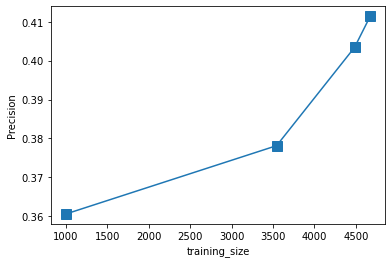

In [31]:
plt.plot(size_training, val_precision, marker='s', markersize = 10)
plt.xlabel('training_size')
plt.ylabel('Precision')

Text(0, 0.5, 'Precision')

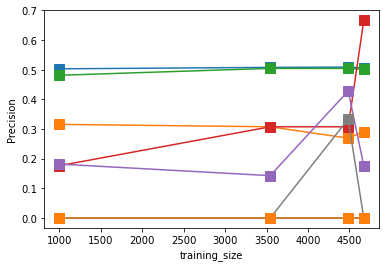

In [32]:
plt.plot(size_training, val_label_precision, marker='s', markersize = 10)
plt.xlabel('training_size')
plt.ylabel('Precision')

Text(0, 0.5, 'Recall')

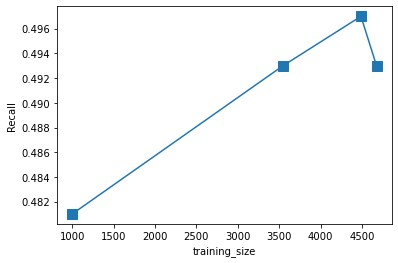

In [33]:
plt.plot(size_training, val_recall, marker='s', markersize = 10)
plt.xlabel('training_size')
plt.ylabel('Recall')

Text(0, 0.5, 'Recall')

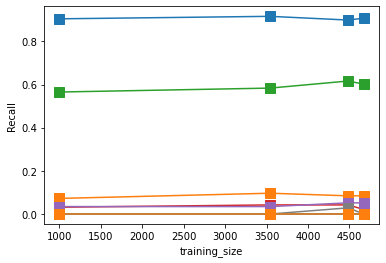

In [34]:
plt.plot(size_training, val_label_recall, marker='s', markersize = 10)
plt.xlabel('training_size')
plt.ylabel('Recall')

<AxesSubplot:>

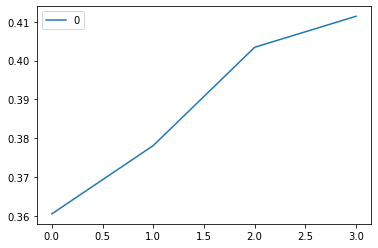

In [35]:
df_precision = pd.DataFrame(val_precision)
df_precision.plot()

<AxesSubplot:>

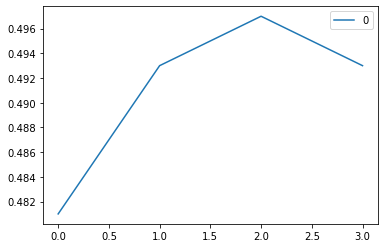

In [36]:
df_recall = pd.DataFrame(val_recall)
df_recall.plot()